<a href="https://colab.research.google.com/github/nilesh0109/ML_SoSe19/blob/master/ML_ex07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

In [0]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

# K-ARM BANDIT CLASS

In [0]:
class K_Arm_Bandit:
  def __init__(self, num_arms, num_episodes=1, num_games_per_episode=1000, epsilons=[0, 0.1]):
    self.k = num_arms
    #num of games in a episode say 1000 in this assigment
    self.num_games = num_games_per_episode
    self.num_episodes = num_episodes
    self.epsilons = epsilons
    self.a = np.arange(self.k, dtype=np.int32)
    num_eps = len(self.epsilons)

    self.optimal_action = np.zeros((self.num_episodes, self.num_games), dtype=np.int32)
    self.chosen_action = np.zeros((self.num_episodes, self.num_games, num_eps), dtype=np.int32)
    self.isOptimalActionChosen = np.zeros((self.num_episodes, self.num_games, num_eps), dtype=bool)
    self.rewards = np.zeros((self.num_episodes, self.num_games, num_eps), dtype=np.float32)
  
  def reset(self):
    '''This r_dist_means gives us the mean of the Normal reward distribution which is in itself comes from a Normal distrubition with zero mean'''
    self.r_dist_means = np.random.normal(size=10)
    
    num_eps = len(self.epsilons)
    self.N_a = np.zeros((self.k, num_eps), dtype=np.int32)
    self.Q = np.zeros((self.k, num_eps), dtype=np.float32)
  
  def getReward(self, acts, episode_ind, game_ind):
    '''Storing the optimal actions for the sake of plots'''
    rewards_for_each_actions = np.array([np.random.normal(reward_mean) for reward_mean in self.r_dist_means])
    self.optimal_action[episode_ind, game_ind]= np.argmax(self.r_dist_means)
    ''' Fetches the reward from a normal distribution given the action index'''
    self.rewards[episode_ind, game_ind] = rewards_for_each_actions[acts]
    self.isOptimalActionChosen[episode_ind, game_ind, :] = acts == np.array([self.optimal_action[episode_ind, game_ind]] * len(acts))
    
  def play_epsilon_greedy(self):
    p = np.random.random()
    nextActions = []
    eps_comps = p > np.array(self.epsilons)
    for eps_index, compartor in enumerate(eps_comps):
      if compartor:
        #print('eps_index is', eps_index)
        chosen_action = np.argmax(self.Q[:, eps_index])
      else:
        #print('else')
        chosen_action = np.random.choice(self.a)
      nextActions.append(chosen_action)
    #print('nextActions is', nextActions)
    return nextActions
  
  def play(self):
    for episode in range(self.num_episodes):
      self.reset()
      self.run_episode(episode)
  
  def run_episode(self, episode):
    for game in range(self.num_games):
      next_actions = self.play_epsilon_greedy()
      self.step(next_actions, episode, game)
  
  def step(self, actions, episode_ind, game_ind):
    #print(actions)
    
    self.N_a[actions, np.arange(len(actions))] += 1
    #print(self.N_a[actions, np.arange(len(actions))])
    self.getReward(actions, episode_ind, game_ind)
    self.chosen_action[episode_ind, game_ind] = actions
    #print('action chosen', actions)
    #print('old action value = ', self.Q[actions, np.arange(len(actions))])
    self.Q[actions, np.arange(len(actions))] +=  (1 / self.N_a[actions, np.arange(len(actions))]) * (self.rewards[episode_ind, game_ind] - self.Q[actions, np.arange(len(actions))])
    #print('reward = ',self.rewards[episode_ind, game_ind], 'action value = ',self.Q[actions, np.arange(len(actions))])
    #print('_________________________________________')
    

# Epsilon Greedy Sample Run

In [68]:
testBed = K_Arm_Bandit(10,num_episodes=10, num_games_per_episode=100, epsilons=[0, 0.1])
testBed.play()
testBed.Q
#testBed.isOptimalActionChosen

array([[-0.15453099, -0.15453099],
       [ 2.2315753 ,  2.2218819 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -0.01956837],
       [ 0.        , -2.1225047 ],
       [ 0.        ,  0.05874836],
       [ 0.        ,  0.        ],
       [ 0.        , -0.3485742 ],
       [ 0.        ,  0.        ]], dtype=float32)

# 2000 Episodes for different epsilons

In [0]:
try_eps = np.array([0, 0.1, 0.01, 0.009], dtype=np.float16)
testBed = K_Arm_Bandit(10,num_episodes=2000, epsilons= try_eps)
testBed.play()

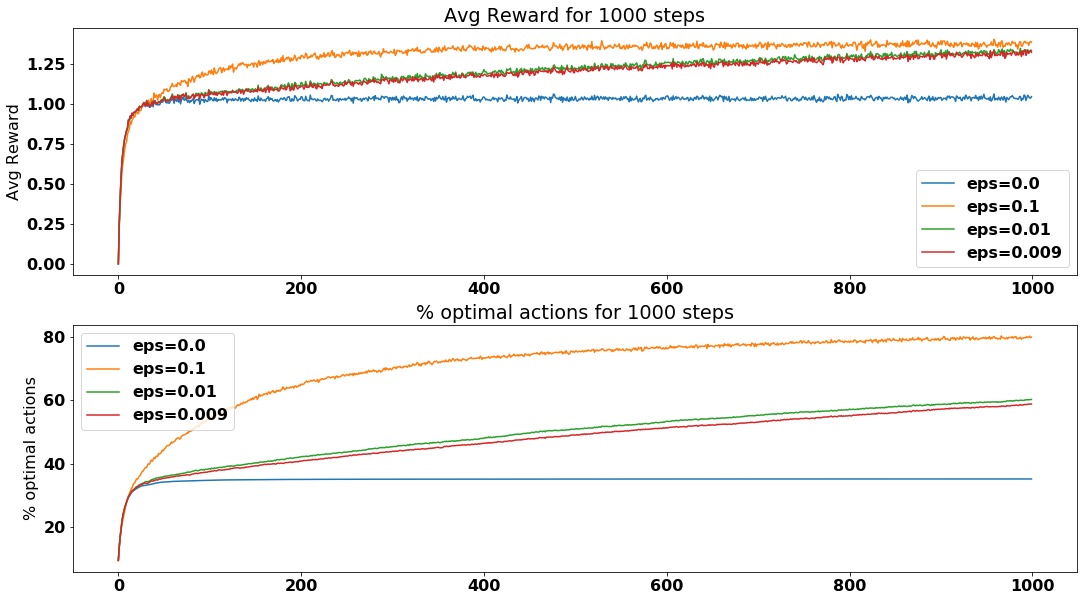

In [78]:
num_episodes, num_games_per_episode, num_eps = testBed.rewards.shape

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(18,10))
for eps_ind in np.arange(num_eps):
  eps_val = round(testBed.epsilons[eps_ind], 3)
  ax1.plot(np.arange(num_games_per_episode),np.mean(testBed.rewards[:,:,eps_ind], axis=0), label='eps='+str(eps_val))
  ax2.plot(np.arange(num_games_per_episode),np.mean(testBed.isOptimalActionChosen[:,:,eps_ind], axis=0)*100, label='eps='+str(eps_val))
ax1.set_title('Avg Reward for {:d} steps'.format(num_games_per_episode))
ax2.set_title('% optimal actions for {:d} steps'.format(num_games_per_episode))
ax1.set_ylabel('Avg Reward', fontsize=16)
ax2.set_ylabel('% optimal actions', fontsize=16)
ax1.legend()
ax2.legend()

# 10000 Run of Different Epsilons

In [0]:
try_eps = np.array([0, 0.1, 0.01, 0.009], dtype=np.float16)
testBed = K_Arm_Bandit(10,num_episodes=10000, epsilons= try_eps)
testBed.play()

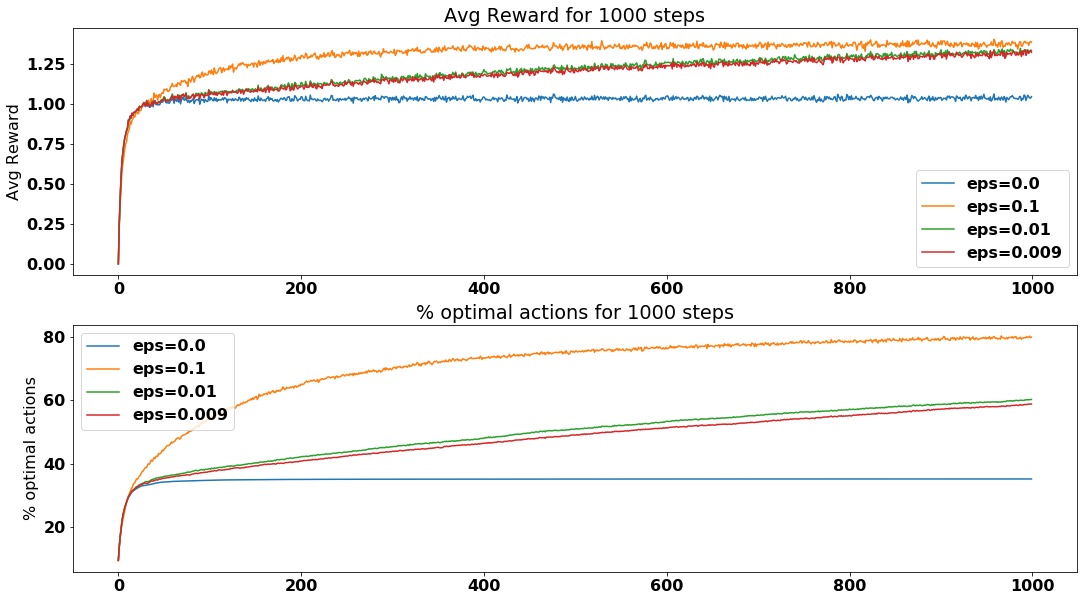

In [77]:
num_episodes, num_games_per_episode, num_eps = testBed.rewards.shape

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(18,10))
for eps_ind in np.arange(num_eps):
  eps_val = round(testBed.epsilons[eps_ind], 3)
  ax1.plot(np.arange(num_games_per_episode),np.mean(testBed.rewards[:,:,eps_ind], axis=0), label='eps='+str(eps_val))
  ax2.plot(np.arange(num_games_per_episode),np.mean(testBed.isOptimalActionChosen[:,:,eps_ind], axis=0)*100, label='eps='+str(eps_val))
ax1.set_title('Avg Reward for {:d} steps'.format(num_games_per_episode))
ax2.set_title('% optimal actions for {:d} steps'.format(num_games_per_episode))
ax1.set_ylabel('Avg Reward', fontsize=16)
ax2.set_ylabel('% optimal actions', fontsize=16)
ax1.legend()
ax2.legend()